In [1]:
import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from utils import plot

%matplotlib inline


ref.
- https://www.kaggle.com/competitions/pcs5022-decalearn-task1
- https://towardsdatascience.com/introduction-on-tensorflow-2-0-bd99eebcdad5 (excelente, veio do treinamento tensor flow da GCP, util no decalearn de imagem tb.)
- https://www.tensorflow.org/guide/tensor?hl=pt-br (documentação oficial)
- https://www.youtube.com/watch?v=5ECD8J3dvDQ (Introduction to TensorFlow 2.0: Easier for beginners, and more powerful for experts (TF World '19))

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

In [3]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from keras.layers import Input
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier  
#from sklearn.wrappers import KerasClassifier

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pickle



In [4]:
def remove_highly_correlated_columns(data, threshold=0.9):
    """
    Remove columns from a NumPy array where the correlation coefficient
    is greater than a specified threshold.

    Parameters:
    - data: np.ndarray, the input array.
    - threshold: float, the correlation coefficient threshold.

    Returns:
    - np.ndarray, the array with highly correlated columns removed.
    """
    if not isinstance(data, np.ndarray):
        raise ValueError("Input data must be a NumPy array.")
    
    corr_matrix = np.corrcoef(data, rowvar=False)
    to_remove = set()
    
    for i in range(corr_matrix.shape[0]):
        for j in range(i+1, corr_matrix.shape[0]):
            if abs(corr_matrix[i, j]) > threshold:
                to_remove.add(j)

    columns_to_keep = [i for i in range(data.shape[1]) if i not in to_remove]
    filtered_data = data[:, columns_to_keep]

    return filtered_data


In [5]:
def reduce_dimensionality(data, variance_threshold=0.95):
    """
    Reduce the dimensionality of a NumPy array using PCA while retaining the specified variance.

    Parameters:
    - data: np.ndarray, the input array with shape (n_samples, n_features).
    - variance_threshold: float, the amount of variance to retain.

    Returns:
    - np.ndarray, the transformed array with reduced dimensions.
    """
    if not isinstance(data, np.ndarray):
        raise ValueError("Input data must be a NumPy array.")
    
    # Initialize PCA to retain the specified amount of variance
    pca = PCA(n_components=variance_threshold)
    
    # Fit the PCA model and transform the data
    reduced_data = pca.fit_transform(data)
    
    return reduced_data

In [6]:
# Function to find the best threshold
def find_best_threshold(y_true, y_pred_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)  # Avoid division by zero
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]
    return best_threshold

In [7]:
# Make predictions on validation data
def check_result(dataset_X_test, dataset_y_test, NN):
    
    y_test_probs = NN.predict(dataset_X_test).ravel()
    
    print('Acurácia default: {:.2f}%'.format(100*accuracy_score(dataset_y_test, y_test_probs > 0.5)))
    
    # Find the best threshold on validation data
    best_threshold = find_best_threshold(dataset_y_test, y_test_probs)
    print(f"Best Threshold: {best_threshold}")

    # Apply the best threshold to make binary predictions
    y_test_pred = (y_test_probs > best_threshold).astype(int)
    print('Acurácia best threshold: {:.2f}%'.format(100*accuracy_score(dataset_y_test, y_test_pred)))

    # Print the predictions
    #print("Predicted probabilities:\n", y_test_probs)
    #print("Predicted classes:\n", y_test_pred)
    #print("True classes:\n", y_test)

In [8]:
class PlotTrainingHistory(Callback):
  def on_train_begin(self, logs={}):
    self.losses = []
    self.val_losses = []
    self.accuracies = []
    self.val_accuracies = []
  
  def on_epoch_end(self, epoch, logs={}):
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.accuracies.append(logs.get('accuracy'))
    self.val_accuracies.append(logs.get('val_accuracy'))

  def plot_history(self):
    plt.plot(self.losses, label='Train Loss')
    plt.plot(self.val_losses, label='Val Loss')
    plt.plot(self.accuracies, label='Train Accuracy')
    plt.plot(self.val_accuracies, label='Val Accuracy')
    plt.title('Model Loss and Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define and compile your Keras model (replace with your model code)

# Create the callback object
plot_history = PlotTrainingHistory()


# Loading Data

In [9]:
# Carrega a base de dados a partir de seu caminho
data = np.load('data/dataset.npz')
print(data.files)

['X_train', 'y_train', 'X_test', 'y_test']


In [10]:
XX_train = data['X_train']
yy_train = data['y_train']
yy_train = yy_train.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
X = XX_train
y = yy_train

unseen_data = data['X_test']
print('features: ', unseen_data.shape)

features:  (100855, 16)


In [11]:
df = pd.DataFrame(X)
df['target'] = y
df.to_csv('dataset.csv')

# DataPrep

In [27]:
def dataprep_full(dataset, target, split = True):
    X_train, X_test, y_train, y_test = None, None, None, None
    
    pearson_threshold = 0.9
    # Create a pipeline for standardization and PCA
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95))
    ])

    dataset = remove_highly_correlated_columns(dataset, pearson_threshold)
    print('features n-correlacionadas: ', dataset.shape)

    if split:
        seed = 7
        test_size = 0.2
        X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=test_size, random_state=seed)
        
        # Transform the features
        X_train = pipeline.fit_transform(X_train)
        X_test = pipeline.transform(X_test)
        #print(X_train.min(axis=0), X_train.max(axis=0))
    else:
        dataset  = pipeline.fit_transform(dataset)

    return dataset, X_train, X_test, y_train, y_test


In [28]:
def dataprep_standardScaler(dataset, target, split = True):
    X_train, X_test, y_train, y_test = None, None, None, None
    
    pearson_threshold = 0.9
    # Create a pipeline for standardization and PCA
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        #('pca', PCA(n_components=0.95))
    ])

    dataset = remove_highly_correlated_columns(dataset, pearson_threshold)
    print('features n-correlacionadas: ', dataset.shape)

    if split:
        seed = 7
        test_size = 0.2
        X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=test_size, random_state=seed)
        
        # Transform the features
        X_train = pipeline.fit_transform(X_train)
        X_test = pipeline.transform(X_test)
        #print(X_train.min(axis=0), X_train.max(axis=0))
    else:
        dataset  = pipeline.fit_transform(dataset)

    return dataset, X_train, X_test, y_train, y_test

In [29]:
def dataprep_pearson(dataset, target, split = True):
    X_train, X_test, y_train, y_test = None, None, None, None
    
    pearson_threshold = 0.9
    dataset = remove_highly_correlated_columns(dataset, pearson_threshold)
    print('features n-correlacionadas: ', dataset.shape)

    if split:
        seed = 7
        test_size = 0.2
        X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=test_size, random_state=seed)
    
    return dataset, X_train, X_test, y_train, y_test

In [30]:
def dataprep_split(dataset, target, split = True):
    X_train, X_test, y_train, y_test = None, None, None, None

    if split:
        seed = 7
        test_size = 0.2
        X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=test_size, random_state=seed)
    
    return dataset, X_train, X_test, y_train, y_test

In [31]:
#matriz de correlação
corr = df.corr()
corr = corr.style.background_gradient(cmap='Blues')
corr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,target
0,1.000000,-0.040302,0.009916,0.060157,-0.049589,0.013996,0.949854,0.299044,0.041746,-0.068842,0.006504,0.038141,0.011889,0.012521,0.010021,0.012200,0.042214
1,-0.040302,1.000000,0.044299,-0.634986,0.412348,-0.004443,-0.039930,0.097943,-0.274696,0.036794,-0.495642,0.118085,0.068704,0.045348,-0.019159,-0.559635,-0.274019
2,0.009916,0.044299,1.000000,-0.053541,0.356885,0.243978,0.015670,0.056087,-0.099478,-0.015545,-0.224363,-0.044501,0.013913,-0.036064,-0.039089,-0.142725,-0.165320
3,0.060157,-0.634986,-0.053541,1.000000,-0.480284,0.034776,0.057455,-0.074090,0.367975,-0.068389,0.576813,-0.125687,-0.042880,-0.056856,0.124549,0.715028,0.387486
4,-0.049589,0.412348,0.356885,-0.480284,1.000000,0.122564,-0.045466,0.125171,-0.242475,0.034629,-0.660228,0.109137,0.114831,0.031823,-0.032077,-0.505745,-0.243002
5,0.013996,-0.004443,0.243978,0.034776,0.122564,1.000000,0.017518,0.022911,0.038089,0.005754,-0.128844,0.019554,0.022205,0.002470,-0.002810,0.027990,0.008449
6,0.949854,-0.039930,0.015670,0.057455,-0.045466,0.017518,1.000000,0.295224,0.041485,-0.066771,-0.003937,0.042857,0.014452,0.014864,0.007036,0.010962,0.046203
7,0.299044,0.097943,0.056087,-0.074090,0.125171,0.022911,0.295224,1.000000,-0.043251,-0.052936,-0.120001,0.021290,0.025772,-0.002425,0.000544,-0.101732,-0.035588
8,0.041746,-0.274696,-0.099478,0.367975,-0.242475,0.038089,0.041485,-0.043251,1.000000,-0.047915,0.275069,0.201792,0.047130,0.082756,0.012718,0.513175,0.252762
9,-0.068842,0.036794,-0.015545,-0.068389,0.034629,0.005754,-0.066771,-0.052936,-0.047915,1.000000,-0.078124,0.020072,0.007048,0.004789,0.002615,-0.092856,-0.011593


In [32]:

X, X_train, X_test, y_train, y_test = dataprep_split(X, y, split = True)
#X, X_train, X_test, y_train, y_test = dataprep_pearson(X, y, split = True)
#X, X_train, X_test, y_train, y_test = dataprep_standardScaler(X, y, split = True)
#X, X_train, X_test, y_train, y_test = dataprep_full(X, y, split = True)

print('features train: ', X_train.shape)
print('features test: ', X_test.shape)
print('target trainning dimensions: ', y_train.shape)
print('target testing dimensions: ', y_test.shape)

features train:  (38221, 16)
features test:  (9556, 16)
target trainning dimensions:  (38221, 1)
target testing dimensions:  (9556, 1)


In [33]:
unique_values, indices, counts = np.unique(y_train, return_index=True, return_counts=True)

print("Unique values:", unique_values)
print("Indices:", indices)
print("Counts:", counts)
print("Proportion:", counts[0]/counts[1])

Unique values: [0 1]
Indices: [1 0]
Counts: [22674 15547]
Proportion: 1.4584164147423941


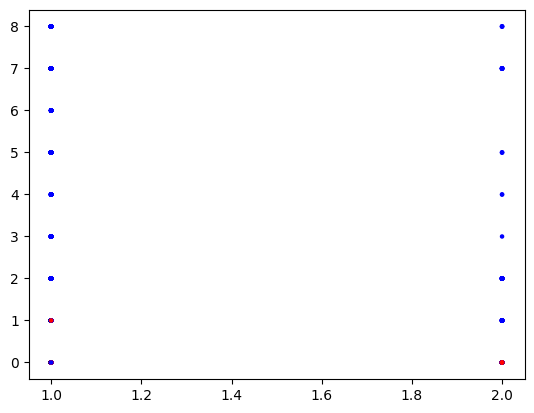

In [34]:
plt.scatter(X_train[:,0], X_train[:,1], c=list(np.array(y_train).ravel()), s=5, cmap='bwr')

In [35]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]
print(input_dim, output_dim)

16 1


In [36]:
from keras import initializers
from keras import models

# First Approach - simple keras network

In [37]:
#numero de neuronios em potencia de base 2
#as camadas mais profundas sao mais especificas da tarefa.
# Define the model swish



model_1 = Sequential()

model_1.add(Input(shape=(input_dim,))) # Input layer 

#model_1.add(Dense(64, activation='relu',kernel_initializer='he_normal'))  # First hidden layer
#model_1.add(BatchNormalization())

model_1.add(Dense(528, activation='relu',kernel_initializer='glorot_normal'))
#model_1.add(Dense(16, activation='relu',kernel_initializer='he_normal'))  # First hidden layer
#model_1.add(BatchNormalization())
#model_1.add(Dropout(0.1))

model_1.add(Dense(528, activation='relu',kernel_initializer='glorot_normal'))   # Second hidden layer
#model_1.add(BatchNormalization())
#model_1.add(Dropout(0.25))

#model_1.add(Dense(4, activation='relu',kernel_initializer='glorot_normal'))   # Second hidden layer
#model_1.add(BatchNormalization()) 
#model_1.add(Dropout(0.25))



#model_1.add(Dense(output_dim, activation='sigmoid', kernel_initializer='glorot_normal'))   # Output hidden layer
model_1.add(Dense(output_dim, activation='sigmoid',kernel_initializer='glorot_normal'))   # Output hidden layer


In [38]:
#Best: 0.8215117341424986 using {'activation': 'swish', 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 70, 'learning_rate': 0.005, 'optimizer': 'adam'}
# Compile the model
optimizer = Adam(learning_rate=1e-2)
model_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#optimizer = SGD(learning_rate=1e-2, momentum=0.9)
#model_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model with a specific batch size
batch_size = 64  # Define your batch size -  Batch Size: Common choices are 32, 64, or 128.
#history = model_1.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1, callbacks=[
#    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#])

#history = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=70, batch_size=batch_size, verbose=1, 
#                      callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])
history = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=batch_size, verbose=1,
                    callbacks=[early_stopping, reduce_lr])

#
#history = model_1.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_data=(X_test, y_test))


Epoch 1/150
598/598 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.7479 - loss: 1.1936 - val_accuracy: 0.7843 - val_loss: 0.4384 - learning_rate: 0.0100
Epoch 2/150
598/598 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7944 - loss: 0.4275 - val_accuracy: 0.7516 - val_loss: 0.4540 - learning_rate: 0.0100
Epoch 3/150
598/598 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7988 - loss: 0.4236 - val_accuracy: 0.8006 - val_loss: 0.4107 - learning_rate: 0.0100
Epoch 4/150
598/598 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8055 - loss: 0.4142 - val_accuracy: 0.7980 - val_loss: 0.4149 - learning_rate: 0.0100
Epoch 5/150
598/598 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7954 - loss: 0.4216 - val_accuracy: 0.7983 - val_loss: 0.4130 - learning_rate: 0.0100
Epoch 6/150
598/598 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7980 - loss: 0.4215 - val_accuracy: 0.7945 - val_loss: 0.4192 - learning_rate: 0.0100
Epoch 7/150
598/598 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8047 -

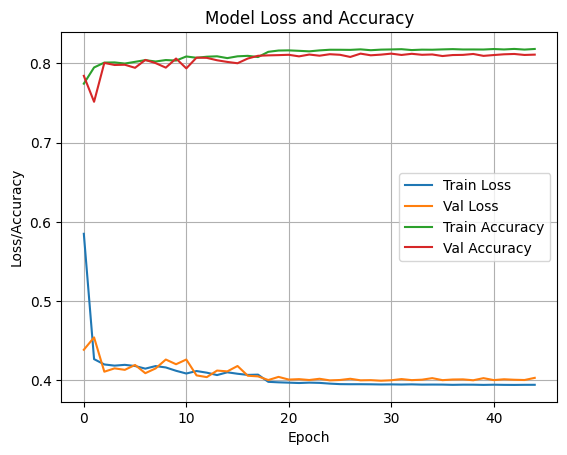

In [39]:
# Plot the training and validation loss/accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Evaluate the model
loss, accuracy = model_1.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
#Best: 0.8158958780576843 using {'activation': 'relu', 'batch_size': 20, 'dropout_rate': 0.0, 'epochs': 50, 'learning_rate': 0.01, 'optimizer': 'adam'}

299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8082 - loss: 0.4041
Loss: 0.3993018865585327
Accuracy: 0.8111134171485901


In [41]:
val_acc_per_epoch = history.history['accuracy']
best_epoch        = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Best epoch: 43


In [42]:
model_1.save('bestANN/model_1.keras')

In [43]:
check_result(dataset_X_test=X_test, dataset_y_test=y_test, NN=model_1)

299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Acurácia default: 81.11%
Best Threshold: 0.327334463596344
Acurácia best threshold: 80.62%


# Second Approach - GridSearchCV com Keras network

In [44]:
# Function to create the model (for use in GridSearchCV)
def create_model(learning_rate=0.01, dropout_rate=0.0, optimizer='adam', init='uniform', activation='relu'):
    
    model = Sequential()
    model.add(Input(shape=(input_dim,))) # Input layer 
    
    model.add(Dense(32, kernel_initializer=init, activation=activation))
    #model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(16, kernel_initializer=init, activation=activation))
    #model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(8, kernel_initializer=init, activation=activation))
    #model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    
    model.add(Dense(output_dim, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [45]:
# Define the grid search parameters
param_grid = {
    'model__init': ['glorot_uniform', 'glorot_normal'],
    'optimizer': ['adam','rmsprop'],
    'activation': ['relu', 'swish'],
    'learning_rate': [0.01, 0.005],
    'dropout_rate': [0.0, 0.1],
    'batch_size': [32, 64],
    'epochs': [50]
}


In [46]:
# Create the KerasClassifier wrapper
model_wrapper = KerasClassifier(model=create_model, epochs=70, batch_size=32, dropout_rate=0.0, learning_rate=0.01, optimizer='adam', init='glorot_uniform', activation='relu', verbose=0)

In [47]:
# Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [48]:
# Create GridSearchCV
grid = GridSearchCV(estimator=model_wrapper, param_grid=param_grid, n_jobs=-1, cv=cv)
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)])
#grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test))
#grid_result = grid.fit(X_train, y_train)
# Plot the training and validation loss/accuracy

c:\Users\cazev\miniconda3\envs\webapp\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/50
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6967 - loss: 0.5793 - val_accuracy: 0.7895 - val_loss: 0.4422
Epoch 2/50
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7662 - loss: 0.4602 - val_accuracy: 0.7970 - val_loss: 0.4272
Epoch 3/50
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7877 - loss: 0.4464 - val_accuracy: 0.7885 - val_loss: 0.4334
Epoch 4/50
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7980 - loss: 0.4303 - val_accuracy: 0.8020 - val_loss: 0.4176
Epoch 5/50
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8011 - loss: 0.4295 - val_accuracy: 0.8002 - val_loss: 0.4167
Epoch 6/50
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8014 - loss: 0.4286 - val_accuracy: 0.8049 - val_loss: 0.4139
Epoch 7/50
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8041 - loss: 0.4206 - val_accuracy: 0.7965 - val_loss: 0.4199
Epoch 8/50
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8043 - loss: 0.4207 - val_accuracy: 0.

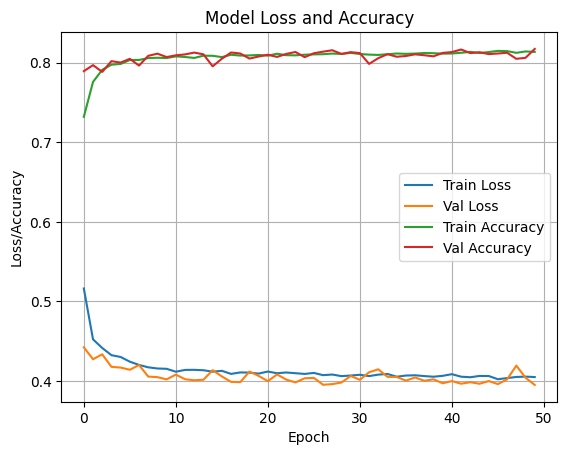

In [49]:
best_history = grid_result.best_estimator_.history_
plt.plot(best_history['loss'], label='Train Loss')
plt.plot(best_history['val_loss'], label='Val Loss')
plt.plot(best_history['accuracy'], label='Train Accuracy')
plt.plot(best_history['val_accuracy'], label='Val Accuracy')
plt.title('Model Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [50]:
# Summarize results
print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')

Best: 0.8194447678789567 using {'activation': 'swish', 'batch_size': 64, 'dropout_rate': 0.1, 'epochs': 50, 'learning_rate': 0.005, 'model__init': 'glorot_normal', 'optimizer': 'rmsprop'}


In [51]:
# Evaluate the model on the test set
best_model = grid_result.best_estimator_.model_
#best_model = grid_result.best_estimator_
print(best_model)

<Sequential name=sequential_1, built=True>


In [52]:
#y_pred = best_model.predict(X_test)
check_result(dataset_X_test=X_test, dataset_y_test=y_test, NN=best_model)

299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Acurácia default: 81.74%
Best Threshold: 0.44423532485961914
Acurácia best threshold: 81.47%


In [53]:
test_loss, test_accuracy = best_model.evaluate(x=X_test,y=y_test,verbose=0)
print(f'Loss: {test_loss}')
print(f'Accuracy: {test_accuracy}')

Loss: 0.3948834240436554
Accuracy: 0.8173922300338745


In [54]:
best_model.save('bestANN/model_2.keras')

# Third Approach - simple custom network

In [55]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]
print(input_dim, output_dim)

16 1


In [56]:
#configuração da rede - problema de classificação binária (binary_cross_entropy)
#nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = 1e-1)
nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = 1e-1,patience=80)
#1 neurônio não é mais suficiente pois n da para separar as classes com uma reta. 
nn.layers.append(Layer(input_dim=input_dim, output_dim=16,activation=rna.relu)) 

nn.layers.append(Layer(input_dim=16, output_dim=8,activation=rna.relu)) 

nn.layers.append(Layer(input_dim=8, output_dim=output_dim,activation=rna.sigmoid)) 

#nn.fit(X_train, y_train, epochs=2000, verbose=200) #porque 1000 epochs ? tentativa e erro !! 
nn.fit(X_train, y_train, x_val=X_test, y_val=y_test, epochs=2000, verbose=50,batch_gen= rna.batch_sequential, batch_size = 64) 


c:\Caio\DevProjects\Python\academico\doutorado\disciplinas\PCS5022 - Redes Neurais\decalearn\task1\Rede_Neural.py:136: RuntimeWarning: divide by zero encountered in divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])
c:\Caio\DevProjects\Python\academico\doutorado\disciplinas\PCS5022 - Redes Neurais\decalearn\task1\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])
c:\Caio\DevProjects\Python\academico\doutorado\disciplinas\PCS5022 - Redes Neurais\decalearn\task1\Rede_Neural.py:431: RuntimeWarning: invalid value encountered in multiply
  dactivation = layer.activation(layer._activ_inp,derivative=True) * last_delta * layer._dropout_mask


epoch:    0/2000 loss_train: nan + nan = nan loss_val = nan
epoch:   50/2000 loss_train: nan + nan = nan loss_val = nan


In [57]:
model_3 = nn
check_result(dataset_X_test= X_test, dataset_y_test=y_test, NN=model_3)
model_3.save('bestANN/model_3.pkl')

Acurácia default: 57.85%


ValueError: Input contains NaN.

# Fourth Approach - simple custom network

In [ ]:
nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = 1e-2,lr_decay_method = rna.staircase_decay, lr_decay_rate=1.0, lr_decay_steps=10, patience=50)
nn.layers.append(Layer(input_dim=input_dim, output_dim=32,activation=rna.relu,weights_initializer=rna.glorot_normal)) 

nn.layers.append(Layer(input_dim=32, output_dim=16,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
nn.layers.append(Layer(input_dim=16, output_dim=8,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))


nn.layers.append(Layer(input_dim=8, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal)) 
nn.fit(X_train, y_train, x_val=X_test, y_val=y_test, epochs=3000, verbose=50,batch_gen= rna.batch_sequential, batch_size = 32) 

epoch:    0/3000 loss_train: 0.43582813 + 0.00000000 = 0.43582813 loss_val = 0.44024860
epoch:   50/3000 loss_train: 0.39215709 + 0.00000000 = 0.39215709 loss_val = 0.40194322
epoch:  100/3000 loss_train: 0.38712529 + 0.00000000 = 0.38712529 loss_val = 0.39994185
epoch:  150/3000 loss_train: 0.38337443 + 0.00000000 = 0.38337443 loss_val = 0.39871794
epoch:  200/3000 loss_train: 0.38120030 + 0.00000000 = 0.38120030 loss_val = 0.39786734
epoch:  250/3000 loss_train: 0.37961146 + 0.00000000 = 0.37961146 loss_val = 0.39732985
epoch:  300/3000 loss_train: 0.37827672 + 0.00000000 = 0.37827672 loss_val = 0.39684862


In [ ]:
model_4 = nn
check_result(dataset_X_test= X_test, dataset_y_test=y_test, NN = model_4)
model_4.save('bestANN/model_4.pkl')

Acurácia default: 81.74%
Best Threshold: 0.38980515817856237
Acurácia best threshold: 81.36%


# Fifth Approach

In [ ]:
neurons = [24,16] 
# preciso encontrar uma forma de implementar a alteração do numero de neuronios na camada oculta variando 
# de n-2 até n+6
hidden_layers = [2,3]
learning_rate = [0.1,0.01]
batch_size = [0,16,32] 
dropout_rate = [0,0.1]
best_of_best_ANN = []
best_of_best_hyper = []

In [ ]:
class hyperparametros: 
    def __init__(self, acuracia, camadas,neuronios,learning_rate,batch_size,dropout): 
        self.acuracia = acuracia 
        self.camadas = camadas
        self.neuronios = neuronios 
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout = dropout

In [ ]:
class ANN_accuracy: 
    def __init__(self, acuracia, _neuralNetwork): 
        self.acuracia = acuracia 
        self.ann = _neuralNetwork

In [ ]:
#patience = early stopping
def setBestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    #nn = NeuralNetwork(cost_func = rna.softmax_neg_log_likelihood, learning_rate = num_learning_rate, momentum=0.1, patience=50) 
    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate,lr_decay_method = rna.staircase_decay, lr_decay_rate=1.0, lr_decay_steps=10,patience=10)

    #camada de entrada
    nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal)) # tanh tb serve
    

    for num_hidden_layers in range(1,hidden_layers+1,1):
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
        nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal,biases_initializer=rna.random_uniform)) # tanh tb serve
      
    #camada de saída
    nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_uniform)) 

    return nn

In [ ]:
def setTestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    #nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.25, patience=50) 

    #camada de entrada
    print('\033[1m Camada de Entrada: {} neurônios inputs  {} neurônios saída {} learning rate \033[0m'.format(input_dim, neurons,num_learning_rate))
    #nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        print(' _camada oculta {} neurônios {} camadas '.format(neurons,hidden_layers))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal))
    
    #nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  
    print('\033[1m {} neurônios da ultima camada oculta, {} neurônios na de saída \033[0m'.format(neurons,output_dim))

In [ ]:
lst_hyperP = []
lst_ANN = []
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    nn = setBestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)
                    
                    nn.fit(X_train, y_train, epochs=5000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=500)
                    y_pred = nn.predict(X_test)
                    #accu = 100*accuracy_score(y_test, y_pred)
                    accu = 100*accuracy_score(y_test, y_pred > 0.5)
                    
                    #print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))
                    lst_hyperP.append(hyperparametros(accu,num_hidden_layers,num_neurons_layers,num_learning_rate,num_batch_size,prob_dropout) )
                    lst_ANN.append(ANN_accuracy(accu,nn))
                    print('Para {} neurônios, {} camadas,  {} learning rate, {} batch size, {} dropout rate, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate,num_batch_size,prob_dropout, accu))


epoch:    0/5000 loss_train: 0.76646767 + 0.00000000 = 0.76646767 loss_val = 0.76646767
Para 24 neurônios, 2 camadas,  0.1 learning rate, 0 batch size, 0 dropout rate, temos:  Acurácia: 79.23% 
epoch:    0/5000 loss_train: 0.80633210 + 0.00000000 = 0.80633210 loss_val = 0.80633210
epoch:  500/5000 loss_train: 0.41888125 + 0.00000000 = 0.41888125 loss_val = 0.41888125
epoch: 1000/5000 loss_train: 0.40553273 + 0.00000000 = 0.40553273 loss_val = 0.40553273
epoch: 1500/5000 loss_train: 0.40071558 + 0.00000000 = 0.40071558 loss_val = 0.40071558
epoch: 2000/5000 loss_train: 0.39799596 + 0.00000000 = 0.39799596 loss_val = 0.39799596
Para 24 neurônios, 2 camadas,  0.1 learning rate, 0 batch size, 0.1 dropout rate, temos:  Acurácia: 80.58% 
epoch:    0/5000 loss_train: 0.70775901 + 0.00000000 = 0.70775901 loss_val = 0.70775901
Para 24 neurônios, 2 camadas,  0.1 learning rate, 16 batch size, 0 dropout rate, temos:  Acurácia: 73.33% 
epoch:    0/5000 loss_train: 0.67182915 + 0.00000000 = 0.671829

KeyboardInterrupt: 

In [ ]:
best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
best_of_best_hyper.append( hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate e {} de batch size!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))


In [ ]:
best_ann = max(lst_ANN, key=lambda hyper: hyper.acuracia)
best_of_best_ANN.append(ANN_accuracy(best_ann.acuracia,best_ann.ann))
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann.acuracia,best_ann.ann))

In [ ]:
lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
for best_hyper in lst_hyperP: 
  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

- funções de ativação
- sigmoid, não usar nas funções ocultas - n é centrada em zero.
- usar tanh satura os gradientes, pode ser um problema, mas ela é centrada em zero e vai de -1 a 1
- funcao relu (mais recomendada) - é uma possibilidade, não satura os gradientes e converge mais rapido que a sigmoid e tanh e outro, só usar nas camadas ocultas. Outro porém da relu é que ela zera os gradientes com saidas negativas e esse pdoe ser um problema para esse caso, pois temos valores negativos aqui.
- Leaky Relu, é uma função que resolve o problema de matar alguns neuronios com o fato de zerar os gradientes. Assim ela vai de -inf;+inf. Tb só usar nas camadas ocultas.
- elu, -inf;+inf, tb reduz chance de matar neuronios, assim como as demais só usar em camadas ocultas.
